In [1]:
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import Image

## Base case 

In [2]:
run_pyNBS_params = {'verbose' : True,
                 
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 
                    
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/base_case/HNSC_KM_plot.png'
                    }

In [3]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [4]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [5]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 2.35332679749 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.95844602585 seconds


In [6]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.9047999382 seconds
Network kernel calculated


In [7]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 23.3989260197 seconds
NBS iteration: 2 complete: 26.1036679745 seconds
NBS iteration: 3 complete: 27.4533760548 seconds
NBS iteration: 4 complete: 32.294975996 seconds
NBS iteration: 5 complete: 29.4608988762 seconds
NBS iteration: 6 complete: 23.2144110203 seconds
NBS iteration: 7 complete: 23.1684172153 seconds
NBS iteration: 8 complete: 22.8369059563 seconds
NBS iteration: 9 complete: 23.6322360039 seconds
NBS iteration: 10 complete: 23.0466091633 seconds
NBS iteration: 11 complete: 22.8628869057 seconds
NBS iteration: 12 complete: 23.8347628117 seconds
NBS iteration: 13 complete: 25.5800619125 seconds
NBS iteration: 14 complete: 32.9436011314 seconds
NBS iteration: 15 complete: 28.6767859459 seconds
NBS iteration: 16 complete: 23.6152858734 seconds
NBS iteration: 17 complete: 22.9983720779 seconds
NBS iteration: 18 complete: 23.1749789715 seconds
NBS iteration: 19 complete: 23.1488509178 seconds
NBS iteration: 20 complete: 23.0388519764 seconds
NBS iterat

In [8]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [9]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Consensus Clustering map saved


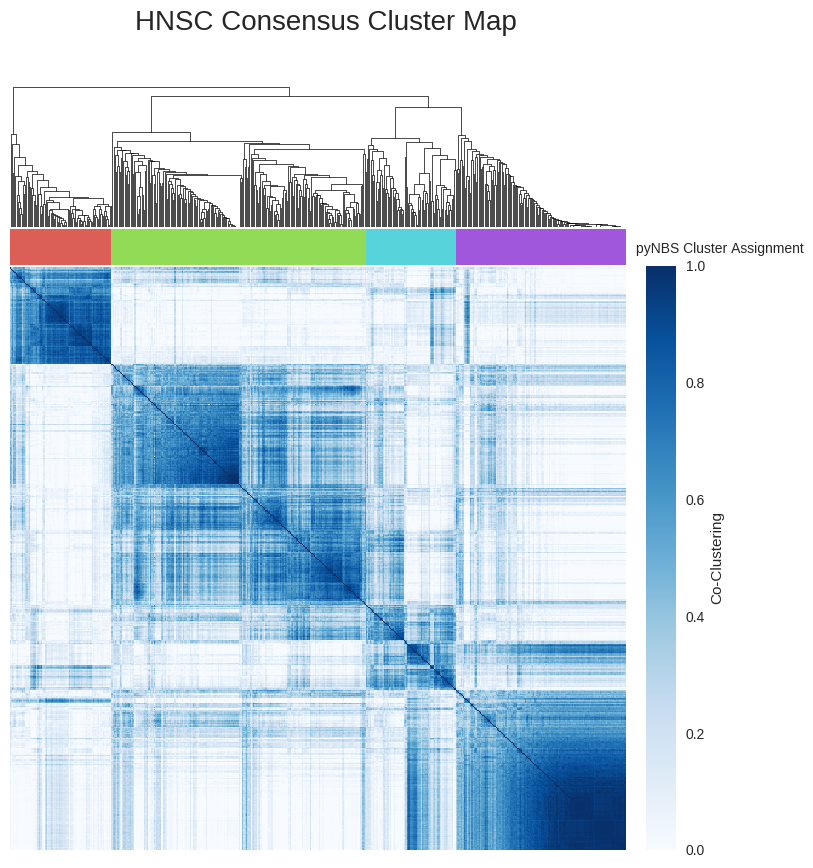

In [10]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.0559649299573


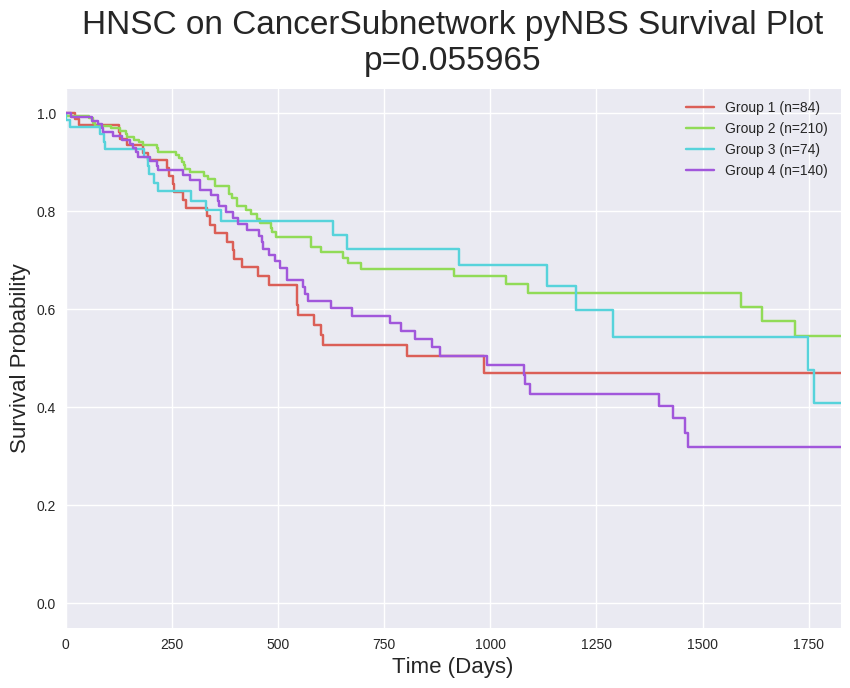

In [11]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign, clin_path, title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Propagation on HumanNet (NH90) network

In [12]:
run_pyNBS_params = {'verbose' : True,
                                    
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    
                    # Using HN90 as network file instead of CancerSubnetwork
                    'network_path' : '~/pyNBS/data/Network_Files/HumanNet90_Symbol.sif',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,

                    'niter' : 100, 
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/HN90/HNSC_KM_plot.png'
                    }

In [13]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [14]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/HumanNet90_Symbol.sif


In [15]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])


Graph influence matrix calculated: 21.7746219635 seconds
Graph laplacian of KNN network from influence matrix calculated: 21.7674891949 seconds


In [16]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 79.7871391773 seconds
Network kernel calculated


In [17]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 105.013395071 seconds
NBS iteration: 2 complete: 103.244754076 seconds
NBS iteration: 3 complete: 102.357033968 seconds
NBS iteration: 4 complete: 102.893906832 seconds
NBS iteration: 5 complete: 102.386088848 seconds
NBS iteration: 6 complete: 103.248975039 seconds
NBS iteration: 7 complete: 103.146512032 seconds
NBS iteration: 8 complete: 102.200259924 seconds
NBS iteration: 9 complete: 103.694375038 seconds
NBS iteration: 10 complete: 103.842499018 seconds
NBS iteration: 11 complete: 102.662868977 seconds
NBS iteration: 12 complete: 102.851374865 seconds
NBS iteration: 13 complete: 103.69509387 seconds
NBS iteration: 14 complete: 102.178431988 seconds
NBS iteration: 15 complete: 102.676941872 seconds
NBS iteration: 16 complete: 102.257733107 seconds
NBS iteration: 17 complete: 102.671029091 seconds
NBS iteration: 18 complete: 103.451503992 seconds
NBS iteration: 19 complete: 103.584080935 seconds
NBS iteration: 20 complete: 102.929357052 seconds
NBS iterat

In [18]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [19]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


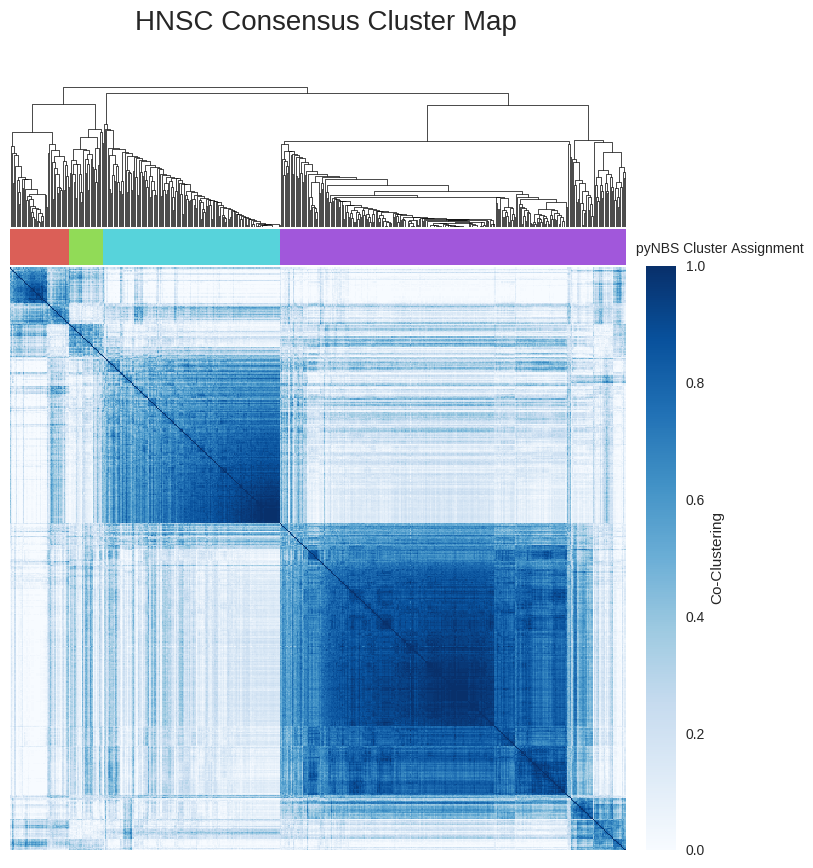

In [20]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.930065528997


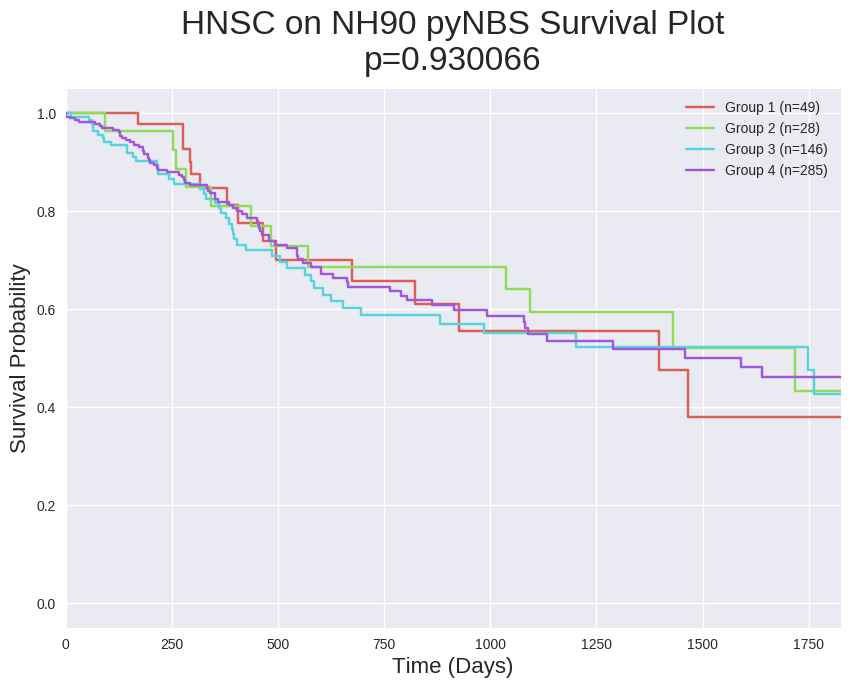

In [21]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on NH90 pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

##  Propagation on Pathway Interation Database (PID) Network

In [22]:
run_pyNBS_params = {'verbose' : True,
                
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    
                    # Using PID as network file instead of CancerSubnetwork
                    'network_path' : '~/pyNBS/data/Network_Files/PID.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,
                    
                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 

                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/PID/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/PID/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/PID/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/PID/HNSC_KM_plot.png'
                    }

In [23]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [24]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/PID.txt


In [25]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.40739917755 seconds
Graph laplacian of KNN network from influence matrix calculated: 5.25144195557 seconds


In [26]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 1.91753697395 seconds
Network kernel calculated


In [27]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 24.9573509693 seconds
NBS iteration: 2 complete: 24.6652929783 seconds
NBS iteration: 3 complete: 25.0807340145 seconds
NBS iteration: 4 complete: 24.9122049809 seconds
NBS iteration: 5 complete: 24.7933690548 seconds
NBS iteration: 6 complete: 24.4345300198 seconds
NBS iteration: 7 complete: 24.7069730759 seconds
NBS iteration: 8 complete: 24.7943940163 seconds
NBS iteration: 9 complete: 24.4285941124 seconds
NBS iteration: 10 complete: 25.1783239841 seconds
NBS iteration: 11 complete: 24.6685049534 seconds
NBS iteration: 12 complete: 24.5146288872 seconds
NBS iteration: 13 complete: 24.458728075 seconds
NBS iteration: 14 complete: 24.6713070869 seconds
NBS iteration: 15 complete: 24.4764461517 seconds
NBS iteration: 16 complete: 24.5879609585 seconds
NBS iteration: 17 complete: 24.6161980629 seconds
NBS iteration: 18 complete: 24.6427509785 seconds
NBS iteration: 19 complete: 24.7264668941 seconds
NBS iteration: 20 complete: 24.4410409927 seconds
NBS iterat

In [28]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [29]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


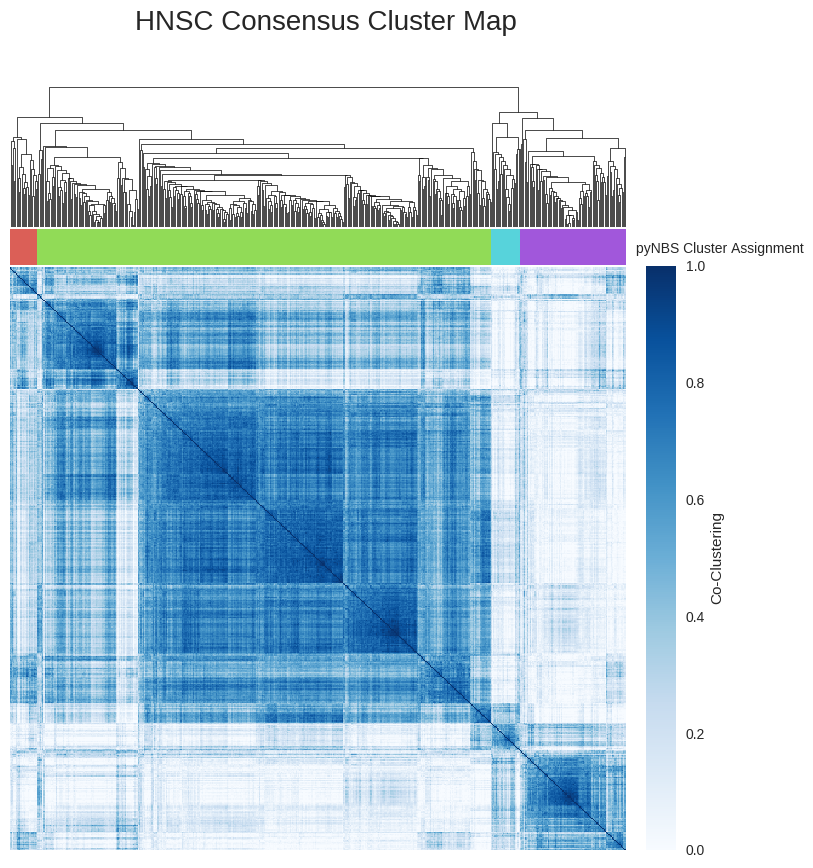

In [30]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 1.93731258583e-05


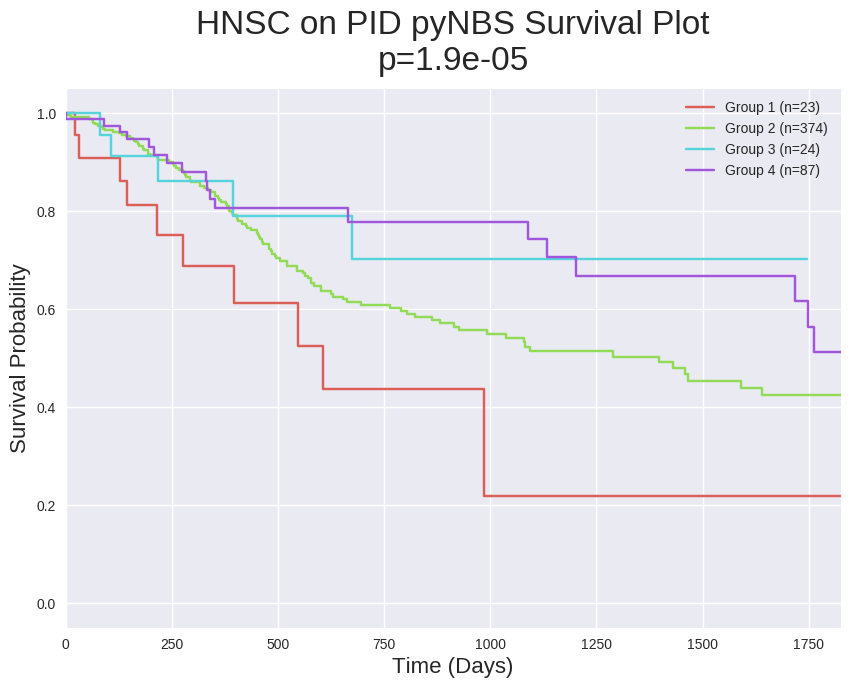

In [31]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on PID pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## No Propagation

In [32]:
run_pyNBS_params = {'verbose' : True,
                                     
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,

                    'niter' : 100, 
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/no_prop/HNSC_KM_plot.png'
                    }

In [33]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : False, # No propagation
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [34]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [35]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.6239759922 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.59402108192 seconds


In [36]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.89124703407 seconds
Network kernel calculated


In [37]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

Somatic mutation data not propagated
NBS iteration: 1 complete: 20.427036047 seconds
Somatic mutation data not propagated
NBS iteration: 2 complete: 20.1964559555 seconds
Somatic mutation data not propagated
NBS iteration: 3 complete: 20.5327239037 seconds
Somatic mutation data not propagated
NBS iteration: 4 complete: 20.1506650448 seconds
Somatic mutation data not propagated
NBS iteration: 5 complete: 20.2520480156 seconds
Somatic mutation data not propagated
NBS iteration: 6 complete: 20.2255849838 seconds
Somatic mutation data not propagated
NBS iteration: 7 complete: 20.6472539902 seconds
Somatic mutation data not propagated
NBS iteration: 8 complete: 20.547465086 seconds
Somatic mutation data not propagated
NBS iteration: 9 complete: 20.3963019848 seconds
Somatic mutation data not propagated
NBS iteration: 10 complete: 20.2270071507 seconds
Somatic mutation data not propagated
NBS iteration: 11 complete: 20.1442849636 seconds
Somatic mutation data not propagated
NBS iteration: 12

In [38]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [39]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


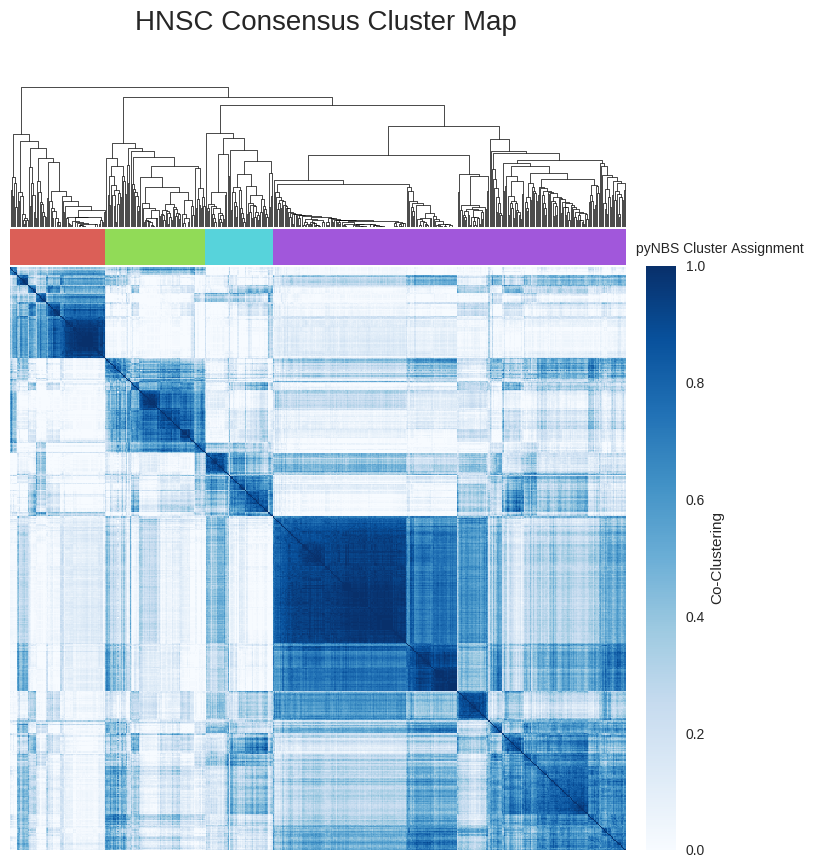

In [40]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.901312036669


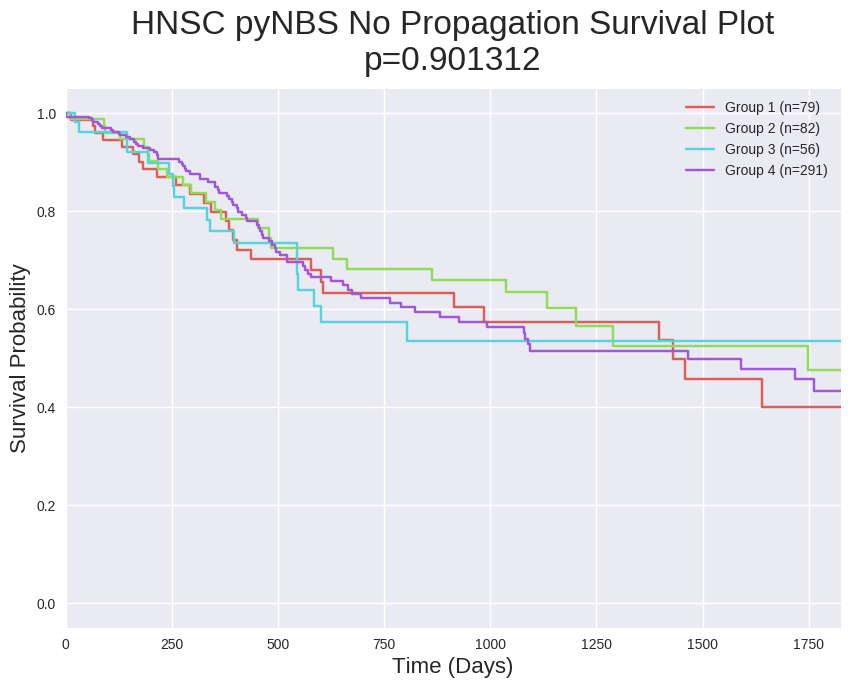

In [41]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC pyNBS No Propagation Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Using symetric degree normalization for random walk propagation 

In [42]:
run_pyNBS_params = {'verbose' : True,
               
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 
                    
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/symetric_norm/HNSC_KM_plot.png'
                    }

In [43]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : True, # Using symetric norm instead of asymetric norm
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [44]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [45]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.71118116379 seconds
Graph laplacian of KNN network from influence matrix calculated: 5.16434407234 seconds


In [46]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 4.28116893768 seconds
Network kernel calculated


In [47]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 22.3198549747 seconds
NBS iteration: 2 complete: 21.9858109951 seconds
NBS iteration: 3 complete: 22.0011949539 seconds
NBS iteration: 4 complete: 21.987612009 seconds
NBS iteration: 5 complete: 22.0666589737 seconds
NBS iteration: 6 complete: 22.332504034 seconds
NBS iteration: 7 complete: 21.8637471199 seconds
NBS iteration: 8 complete: 21.9397938251 seconds
NBS iteration: 9 complete: 21.9485118389 seconds
NBS iteration: 10 complete: 21.9609808922 seconds
NBS iteration: 11 complete: 22.201086998 seconds
NBS iteration: 12 complete: 22.0033609867 seconds
NBS iteration: 13 complete: 21.9602248669 seconds
NBS iteration: 14 complete: 21.908285141 seconds
NBS iteration: 15 complete: 21.8765559196 seconds
NBS iteration: 16 complete: 22.0802769661 seconds
NBS iteration: 17 complete: 22.1325170994 seconds
NBS iteration: 18 complete: 22.0304729939 seconds
NBS iteration: 19 complete: 21.808934927 seconds
NBS iteration: 20 complete: 21.9384939671 seconds
NBS iteration:

In [48]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [49]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


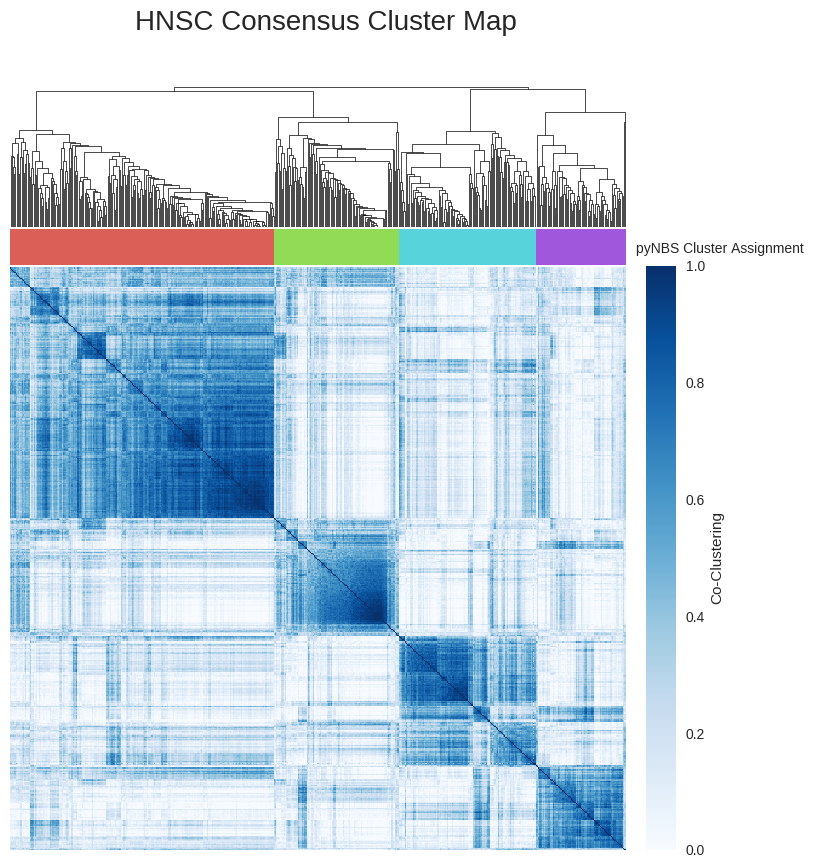

In [50]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.431208348852


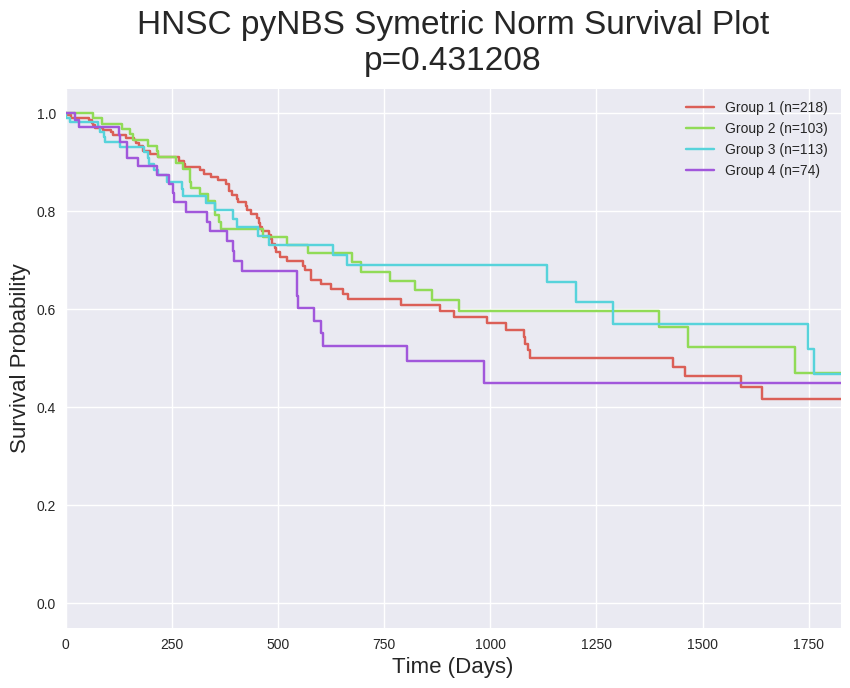

In [51]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC pyNBS Symetric Norm Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Subsampling 50% of patients and 50% of genes

In [52]:
run_pyNBS_params = {'verbose' : True,
               
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 
                    
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/subsample_50/HNSC_KM_plot.png'
                    }

In [53]:
NBS_options = {'pats_subsample_p' : 0.5, # Subsmapling 50% of patients
               'gene_subsample_p' : 0.5, # Subsampling 50% of genes
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [54]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [55]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.75162100792 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.63163208961 seconds


In [56]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 4.05808997154 seconds
Network kernel calculated


In [57]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 14.7010171413 seconds
NBS iteration: 2 complete: 14.4963538647 seconds
NBS iteration: 3 complete: 14.7475101948 seconds
NBS iteration: 4 complete: 14.827901125 seconds
NBS iteration: 5 complete: 14.4329152107 seconds
NBS iteration: 6 complete: 14.5722219944 seconds
NBS iteration: 7 complete: 14.712941885 seconds
NBS iteration: 8 complete: 14.7126669884 seconds
NBS iteration: 9 complete: 14.5275971889 seconds
NBS iteration: 10 complete: 14.4438331127 seconds
NBS iteration: 11 complete: 14.3645908833 seconds
NBS iteration: 12 complete: 14.8256180286 seconds
NBS iteration: 13 complete: 14.8163890839 seconds
NBS iteration: 14 complete: 14.6635279655 seconds
NBS iteration: 15 complete: 14.4549911022 seconds
NBS iteration: 16 complete: 14.7160828114 seconds
NBS iteration: 17 complete: 14.5546660423 seconds
NBS iteration: 18 complete: 14.724616766 seconds
NBS iteration: 19 complete: 14.7311069965 seconds
NBS iteration: 20 complete: 14.395442009 seconds
NBS iteration

In [58]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [59]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


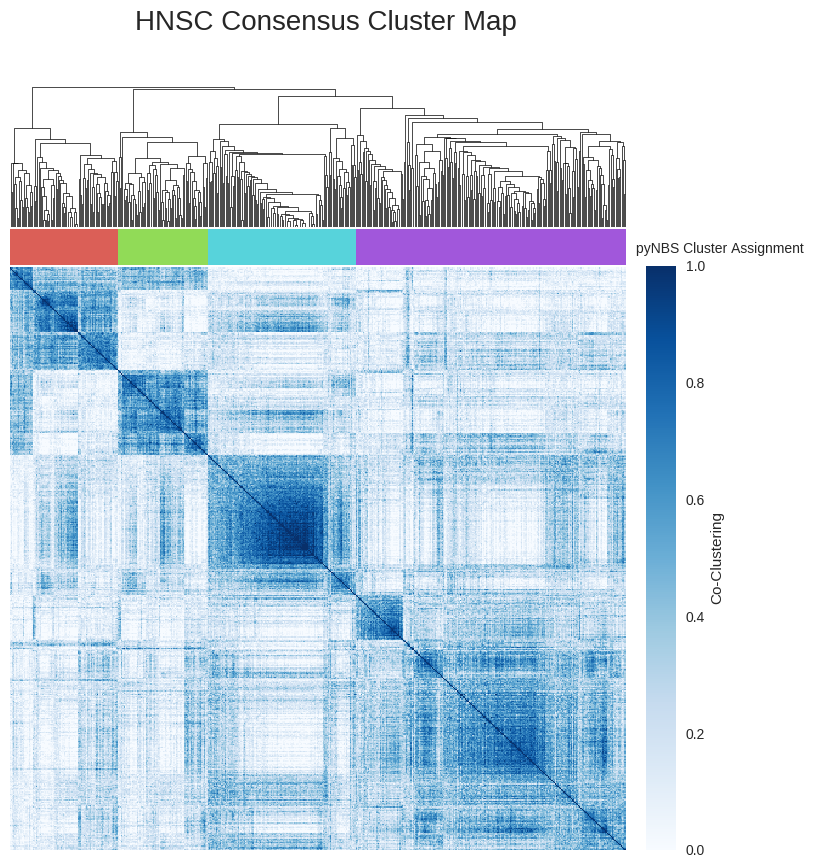

In [60]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.302617321925


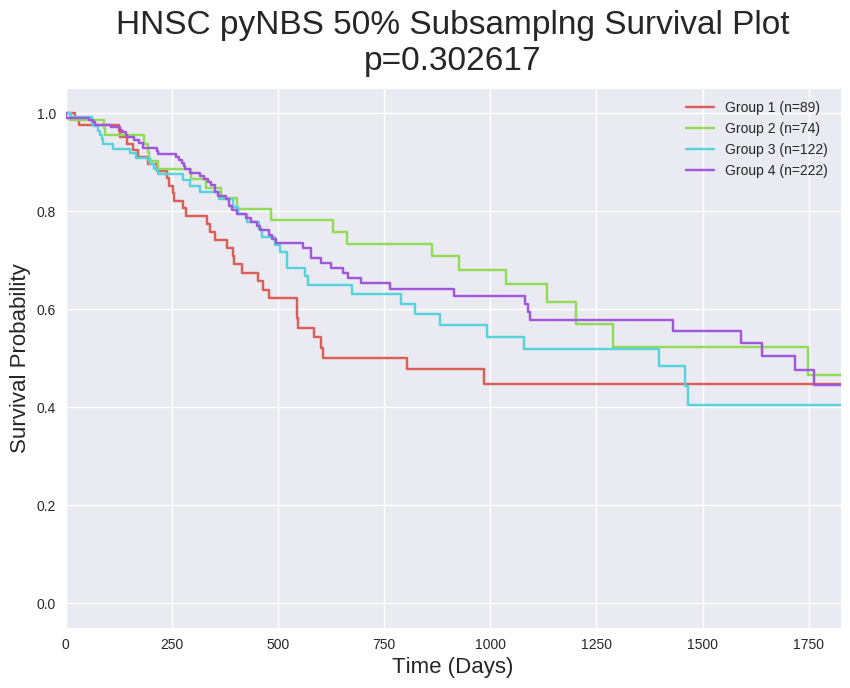

In [61]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC pyNBS 50% Subsamplng Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Number of clusters, k = 5

In [62]:
run_pyNBS_params = {'verbose' : True,
                
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 
                    
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/k/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/k/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/k/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/k/HNSC_KM_plot.png'
                    }

In [63]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 5, # 5 clusters for netNMF
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [64]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [65]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.74207997322 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.65912985802 seconds


In [66]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.68320202827 seconds
Network kernel calculated


In [67]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 27.4495179653 seconds
NBS iteration: 2 complete: 26.2581269741 seconds
NBS iteration: 3 complete: 26.6665091515 seconds
NBS iteration: 4 complete: 26.5006480217 seconds
NBS iteration: 5 complete: 26.8887021542 seconds
NBS iteration: 6 complete: 26.5510561466 seconds
NBS iteration: 7 complete: 26.6613068581 seconds
NBS iteration: 8 complete: 26.3424870968 seconds
NBS iteration: 9 complete: 26.4595448971 seconds
NBS iteration: 10 complete: 26.7236011028 seconds
NBS iteration: 11 complete: 26.5179679394 seconds
NBS iteration: 12 complete: 26.5913438797 seconds
NBS iteration: 13 complete: 26.3813230991 seconds
NBS iteration: 14 complete: 26.7928469181 seconds
NBS iteration: 15 complete: 26.5422861576 seconds
NBS iteration: 16 complete: 26.587816 seconds
NBS iteration: 17 complete: 26.6846179962 seconds
NBS iteration: 18 complete: 26.2123808861 seconds
NBS iteration: 19 complete: 26.430150032 seconds
NBS iteration: 20 complete: 26.7228159904 seconds
NBS iteration:

In [68]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [69]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


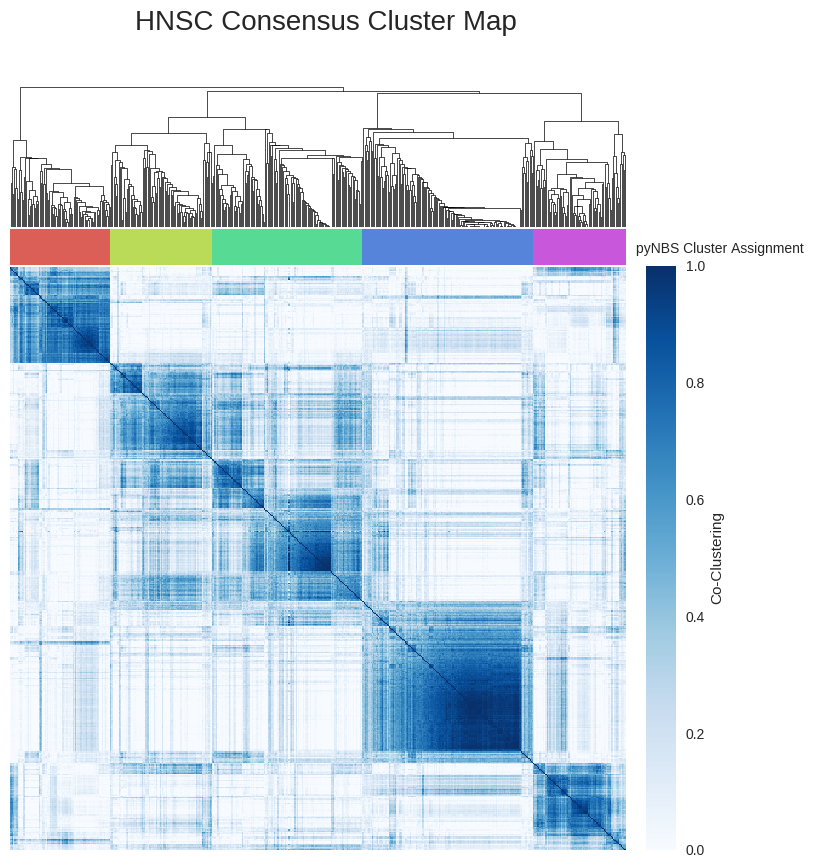

In [70]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Multi-Class Log-Rank P: 0.112068699361


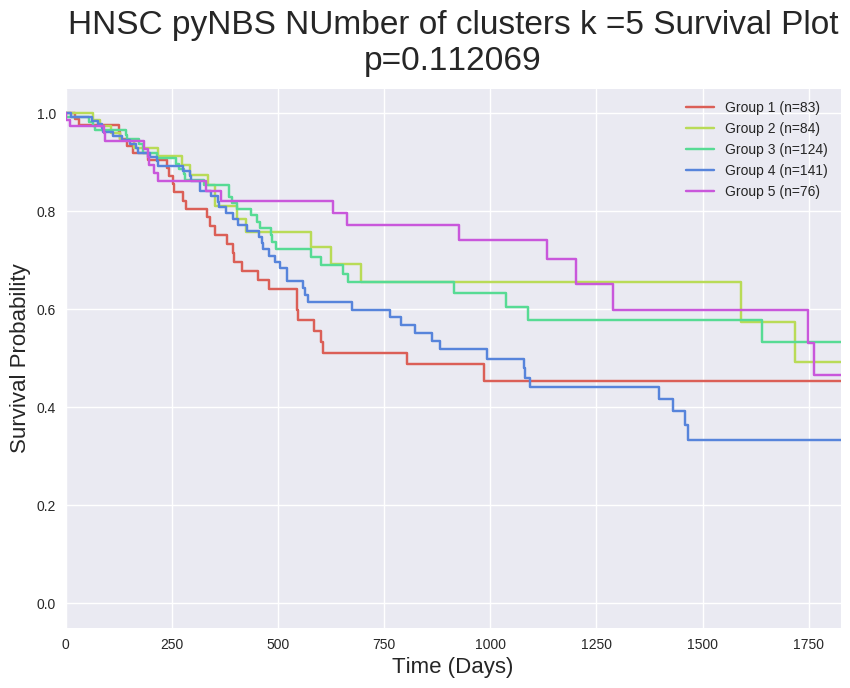

In [71]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC pyNBS NUmber of clusters k =5 Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)

## Number of iterations for sub-sampling, n = 100; Number of netNMF iteration, netNMF = 50

In [72]:
run_pyNBS_params = {'verbose' : True,
                
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,

                    'niter' : 100, # 100 iterations for sub-sampling 
                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Supplementary_Notebooks/results/net_nmf/HNSC_KM_plot.png'
                    }

In [73]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 50, # 50 iterations in netNMF
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

In [74]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


In [75]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.82358813286 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.61252903938 seconds


In [76]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.73184680939 seconds
Network kernel calculated


In [77]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 6.04851794243 seconds
NBS iteration: 2 complete: 5.52031087875 seconds
NBS iteration: 3 complete: 5.51115202904 seconds
NBS iteration: 4 complete: 5.61676621437 seconds
NBS iteration: 5 complete: 5.58326292038 seconds
NBS iteration: 6 complete: 5.51866602898 seconds
NBS iteration: 7 complete: 5.51788592339 seconds
NBS iteration: 8 complete: 5.55256676674 seconds
NBS iteration: 9 complete: 5.58253502846 seconds
NBS iteration: 10 complete: 5.54621386528 seconds
NBS iteration: 11 complete: 5.5463540554 seconds
NBS iteration: 12 complete: 5.53045511246 seconds
NBS iteration: 13 complete: 5.48522782326 seconds
NBS iteration: 14 complete: 5.5094268322 seconds
NBS iteration: 15 complete: 5.53578686714 seconds
NBS iteration: 16 complete: 5.61403298378 seconds
NBS iteration: 17 complete: 5.74422097206 seconds
NBS iteration: 18 complete: 5.52477884293 seconds
NBS iteration: 19 complete: 5.5994849205 seconds
NBS iteration: 20 complete: 5.55234289169 seconds
NBS iteratio

In [78]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'

Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [79]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

Consensus Clustering map saved


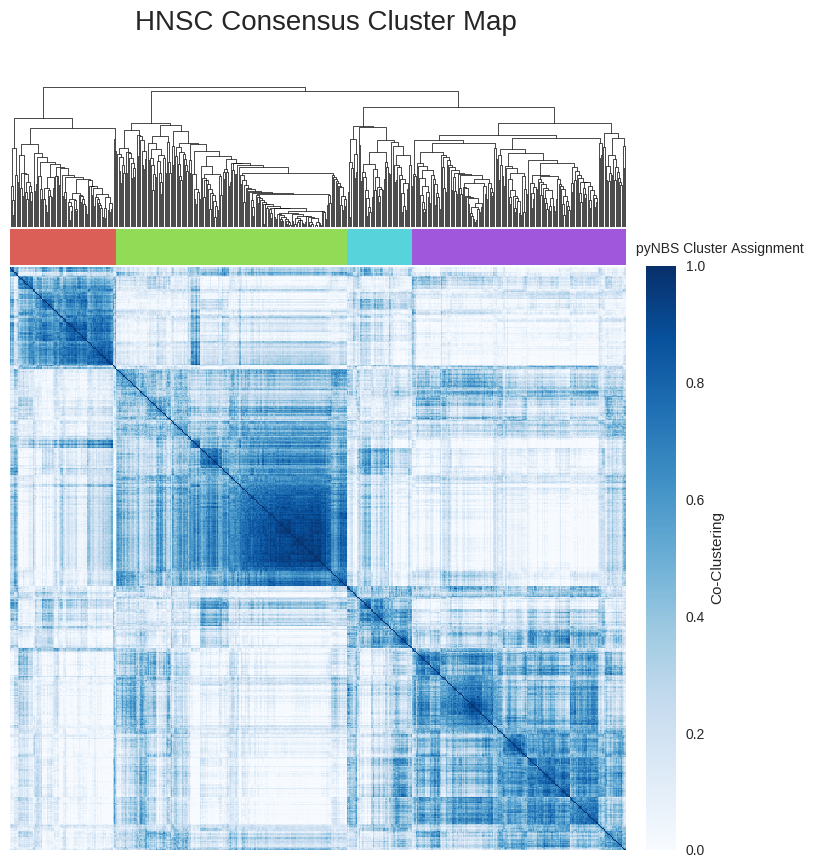

In [80]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

Multi-Class Log-Rank P: 0.00910161848673


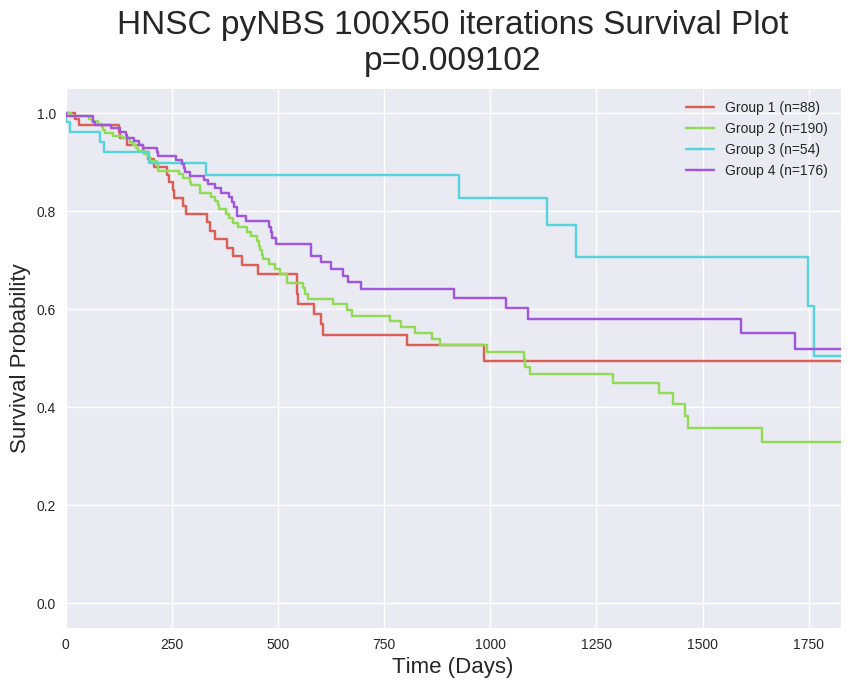

In [81]:
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'
plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC pyNBS 100X50 iterations Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)